In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9
from scipy import integrate

In [2]:
def generate_observed_params(nsamples, truth=False):

    if(truth == False):
        logphi1 = np.random.normal([-2.44, -3.08, -4.14], [0.04, 0.05, 0.2], (nsamples, 3))
        logphi2 = np.random.normal([-2.89, -3.29, -3.51], [0.07, 0.06, 0.06], (nsamples, 3))
        logm_star = np.random.normal([10.79, 10.88, 10.84], [0.04, 0.04, 0.08], (nsamples, 3))
        #alpha1 = np.random.uniform(-0.5 , 1, nsamples)
        #alpha2 = np.random.uniform(-2 , -0.5, nsamples)
        alpha1 = np.random.normal(-0.28 , 0.14, nsamples)
        alpha2 = np.random.normal(-1.48 , 0.04, nsamples)
    else:
        logphi1 = np.array([[-2.44, -3.08, -4.14]])
        logphi2 = np.array([[-2.89, -3.29, -3.51]])
        logm_star = np.array([[10.79, 10.88, 10.84]])
        alpha1 = np.array([[-0.28]])
        alpha2 = np.array([[-1.48]])

    return [logphi1, logphi2, logm_star, alpha1, alpha2]

In [3]:
def get_quadratic_coeffs(samples):

    y1 = samples[:, 2]
    y2 = samples[:, 1]
    y3 = samples[:, 0]

    z1 = 3.0
    z2 = 1.6
    z3 = 0.2

    a = ((y3-y1) + ((y2-y1) / (z2-z1)) * (z1-z3)) / ((z3**2-z1**2 + ((z2**2-z1**2) / (z2-z1)) * (z1-z3)))
    b = ((y2-y1) - a * (z2**2-z1**2)) / (z2-z1)
    c = y1-a*z1**2-b*z1

    return np.transpose(np.vstack((a, b, c)))

In [4]:
def mass_function_parameter_curves(z_grid, nsamples, truth):

    observed_mass_function_parameters = generate_observed_params(nsamples, truth)
    redshift_dependent_parameters = observed_mass_function_parameters[:3]
    alphas = observed_mass_function_parameters[3:]

    curves = []
    i = 0
    for param in redshift_dependent_parameters:
        coeffs = get_quadratic_coeffs(param)
        a = np.reshape(coeffs[:, 0], (nsamples, 1))
        b = np.reshape(coeffs[:, 1], (nsamples, 1))
        c = np.reshape(coeffs[:, 2], (nsamples, 1))
        z_grid_tile = np.tile(z_grid, (nsamples, 1))

        if(truth):
            logparam = c*np.ones_like(z_grid_tile) + b*z_grid_tile + a*z_grid_tile*z_grid_tile
        else:
            if(i == 2):
                logparam = c*np.ones_like(z_grid_tile) + b*z_grid_tile + a*z_grid_tile*z_grid_tile
            else:
                logparam = c*np.ones_like(z_grid_tile) - abs(b)*z_grid_tile #+ a*z_grid_tile*z_grid_tile
        i+=1

        curves.append(logparam)

    for aparam in alphas:
        z_grid_tile = np.tile(z_grid, (nsamples, 1))
        alpha_param = np.reshape(aparam, (nsamples, 1))
        alpha_param = alpha_param*np.ones_like(z_grid_tile)
        curves.append(alpha_param)

    return curves

In [5]:
def select_allowed_parameter_curves(z_grid, curves):

    redshift_dependent_curves =  curves[:3]
    alphas = curves[3:]
    selected_curves = []
    prior_bounds = [np.array([-6, -2]), np.array([-6, -2]), np.array([10, 12])]
    i = 0
    for param in redshift_dependent_curves:
        param_df = pd.DataFrame(param, columns=z_grid)
        param_df.drop(param_df[param_df[z_grid[-1]] > prior_bounds[i][1]].index, axis=0, inplace=True)
        param_df.drop(param_df[param_df[z_grid[-1]] < prior_bounds[i][0]].index, axis=0, inplace=True)
        selected_curves.append(param_df.to_numpy())
        i+=1

    for aparam in alphas:
        selected_curves.append(aparam)

    return selected_curves

In [6]:
def plot_mass_function_parameter_curves(z_grid, curves, **kwargs):

    fig, axes = plt.subplots(1, 5)
    fig.set_figheight(10)
    fig.set_figwidth(30)
    ylabels = ['log$_{10}\phi_{1}$', 'log$_{10}\phi_{2}$', 'log$_{10}\mathrm{M}_{*}$',r'$\alpha_{1}$', r'$\alpha_{2}$']
    plot_no = 0
    for param in curves:
        i = 0
        ncurves = curves[plot_no].shape[0]
        while(i < ncurves):
            axes[plot_no].plot(z_grid, param[i, :], c='purple', **kwargs)
            axes[plot_no].set_xlabel('$z$', fontsize=20)
            axes[plot_no].set_ylabel(ylabels[plot_no], fontsize=20)
            i+=1
        plot_no+=1

In [7]:
def sample_allowed_parameter_curves(z_grid, nsamples, allowed_curves):

    sampled_curves = []

    for param in allowed_curves:
        ncurves = param.shape[0]
        if(ncurves < nsamples):
            raise Exception("Requesting too many samples, try lowering nsamples")
        random_indexes = np.random.randint(0, ncurves, nsamples)
        param_df = pd.DataFrame(param, columns=z_grid)
        param_df = param_df.loc[random_indexes]
        sampled_curves.append(param_df.to_numpy())

    return sampled_curves

In [8]:
def schechter(logm, logphi, logm_star, alpha):

    ones = np.ones_like(alpha)
    
    return np.log(10)*(10**logphi)*10**((logm-logm_star)*(alpha+ones))*np.exp(-10**(logm-logm_star))

def mass_function(logm, sampled_mass_parameter_curves):

    nmasses = len(logm)
    logphi1, logphi2, logm_star, alpha1, alpha2 = sampled_mass_parameter_curves

    logphi1 = np.tile(logphi1, (nmasses, 1, 1))
    logphi2 = np.tile(logphi2, (nmasses, 1, 1))
    logm_star = np.tile(logm_star, (nmasses, 1, 1))
    alpha1 = np.tile(alpha1, (nmasses, 1, 1))
    alpha2 = np.tile(alpha2, (nmasses, 1, 1))

    logm = np.reshape(logm, (nmasses, 1, 1))

    mfunc = schechter(logm, logphi1, logm_star, alpha1) + schechter(logm, logphi2, logm_star, alpha2)
    #mfunc = np.where(mfunc < 1e-5, 1e-5, mfunc)
    return np.log10(mfunc)

In [9]:
def plot_observed_mass_function():
    
    z_grid = np.linspace(0.0, 2.0, 5)
    logm_grid = np.linspace(8, 12, 100)
    observed_parameter_curves = mass_function_parameter_curves(z_grid, 1, truth=True)
    mass_func = np.split(mass_function(logm_grid, observed_parameter_curves), 5, axis=2) #axis=0, is logm, axis=1 is samples, axis=2 is z

    colours = plt.cm.Reds(np.linspace(0,1,len(z_grid)))

    i = 0
    for fun in mass_func:
        plt.plot(logm_grid, np.reshape(fun, (100,)), color=colours[i], label=str(z_grid[i]))
        i+=1

    plt.ylim(-5, -1)
    plt.xlabel('log(M/M*)')
    plt.ylabel('log($\Phi$/Mpc-3/dex)')
    plt.legend()

In [10]:
def volume_element(z, dz):
    return WMAP9.comoving_volume(z+dz).value - WMAP9.comoving_volume(z).value

In [11]:
def volume_elements(z_grid):

    dz = z_grid[-1]-z_grid[-2]
    volumes = []
    for z in z_grid:
        volumes.append(volume_element(z, dz))

    return np.array(volumes)

In [12]:
def plot_observed_nz():
    
    z_grid = np.linspace(0.0, 3.0, 100)
    logm_grid = np.linspace(10, 10, 1)
    observed_parameter_curves = mass_function_parameter_curves(z_grid, 1, truth=True)
    mass_func = np.reshape(10**mass_function(logm_grid, observed_parameter_curves), (100,))
    nz = mass_func*volume_elements(z_grid)
    nz = nz/np.trapz(nz, z_grid)

    plt.plot(z_grid, nz)
    plt.xlabel('z')
    plt.ylabel('p(z|logm)')

In [43]:
def draw_allowed_parameter_curves(z_grid, init_sample, nsamples):

    curves = mass_function_parameter_curves(z_grid, init_sample, truth=False)
    allowed_curves = select_allowed_parameter_curves(z_grid, curves)
    sampled_curves = sample_allowed_parameter_curves(z_grid, nsamples, allowed_curves)

    return sampled_curves

In [27]:
def draw_nz_prior(z_grid, logm_grid, sampled_curves):

    volume_grid = volume_elements(z_grid)
    phi_z_logm = 10**mass_function(logm_grid, sampled_curves)

    i = 0
    logm_len = len(logm_grid)
    z_len = len(z_grid)
    nz = np.zeros_like(phi_z_logm[0,:,:])
    while(i < logm_len):
        nz_samples_at_logm = np.reshape(phi_z_logm[i,:,:]*volume_grid, (z_len,))
        nz_samples_at_logm = nz_samples_at_logm/np.trapz(nz_samples_at_logm, z_grid)
        nz += nz_samples_at_logm
        i+=1

    
    nz = np.reshape(nz, (z_len,))
    nz = nz/np.trapz(nz, z_grid)

    return nz

In [30]:
def plot_nz_prior_draws(z_grid, logm_grid, sampled_curves, nsamples):
    i = 0
    while(i < nsamples):
        plt.plot(z_grid, draw_nz_prior(z_grid, logm_grid, sampled_curves), alpha=0.1, c='purple')
        i+=1

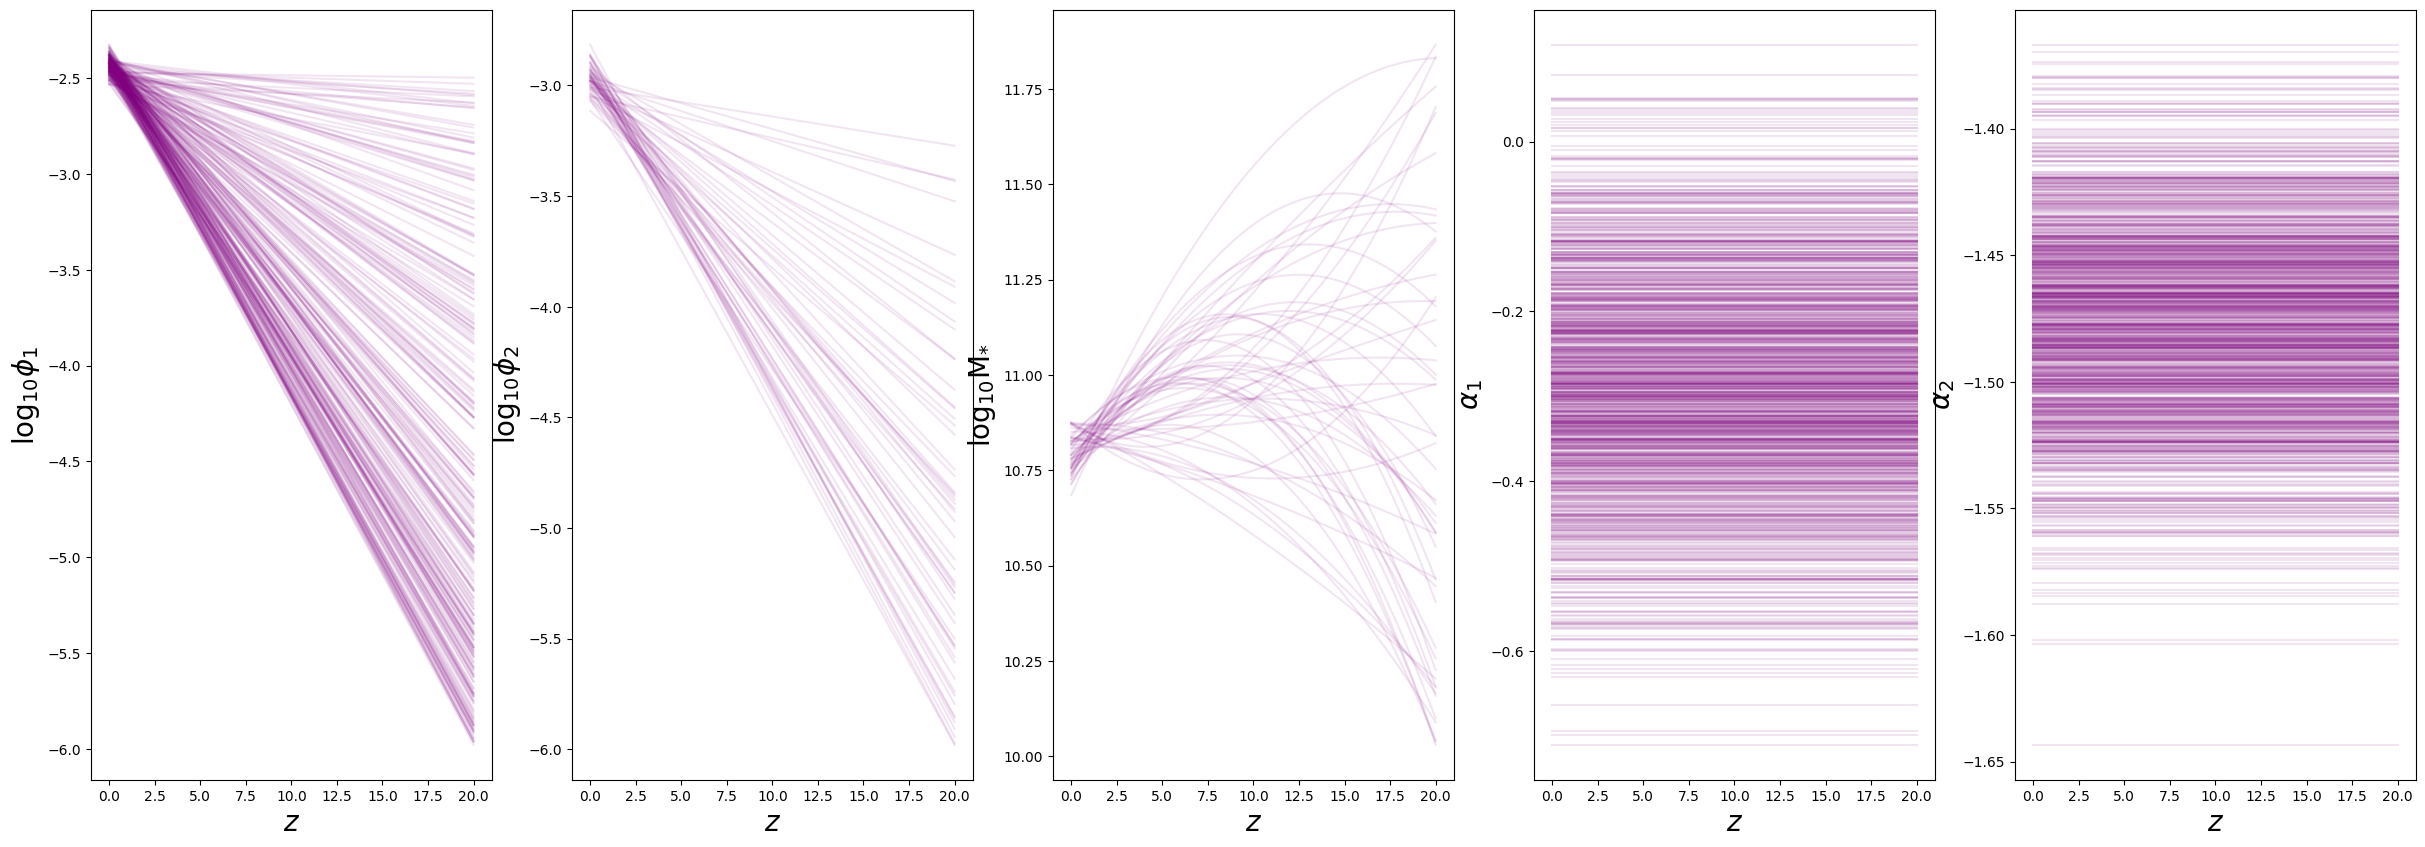

In [15]:
z_grid = np.linspace(0.0, 20.0, 50)
nsamples=1000
curves = mass_function_parameter_curves(z_grid, nsamples, truth=False)
selected_curves = select_allowed_parameter_curves(z_grid, curves)
plot_mass_function_parameter_curves(z_grid, selected_curves, alpha=0.1)


(1000, 50) (1000, 50) (1000, 50) (1000, 50) (1000, 50)


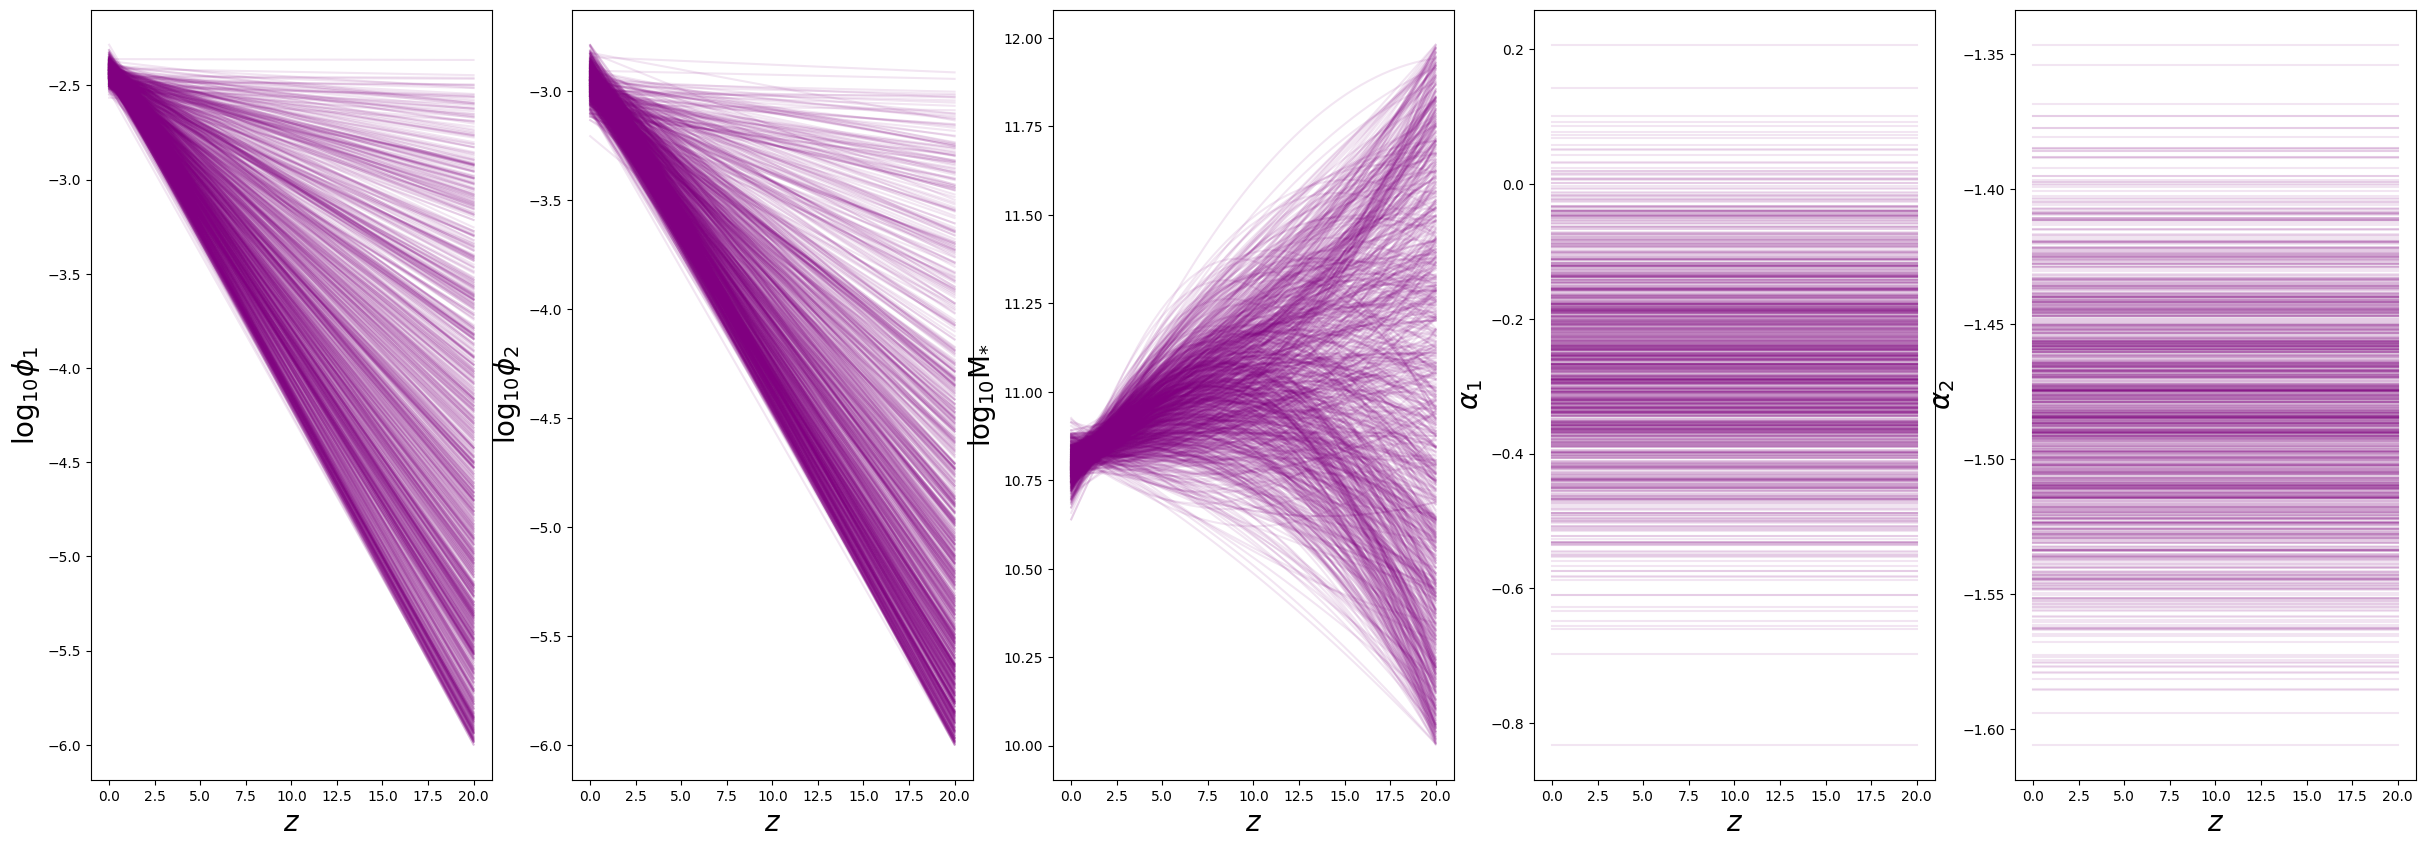

In [16]:
z_grid = np.linspace(0.0, 20.0, 50)
nsamples=1000000
curves = mass_function_parameter_curves(z_grid, nsamples, truth=False)
allowed_curves = select_allowed_parameter_curves(z_grid, curves)

sampled_curves = sample_allowed_parameter_curves(z_grid, 1000, allowed_curves)
print(sampled_curves[0].shape, sampled_curves[1].shape, sampled_curves[2].shape, sampled_curves[3].shape, sampled_curves[4].shape)
plot_mass_function_parameter_curves(z_grid, sampled_curves, alpha=0.1)

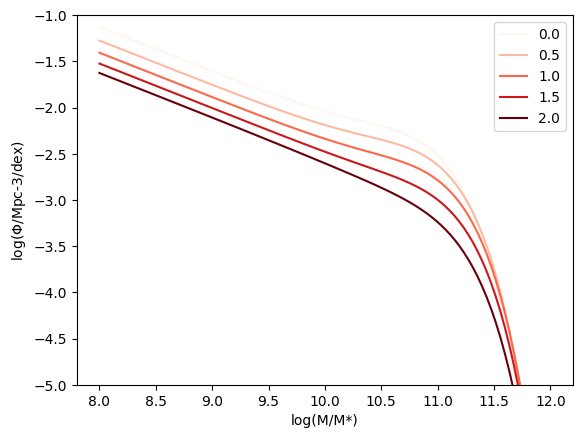

In [17]:
plot_observed_mass_function()

(0.0, 3.0)

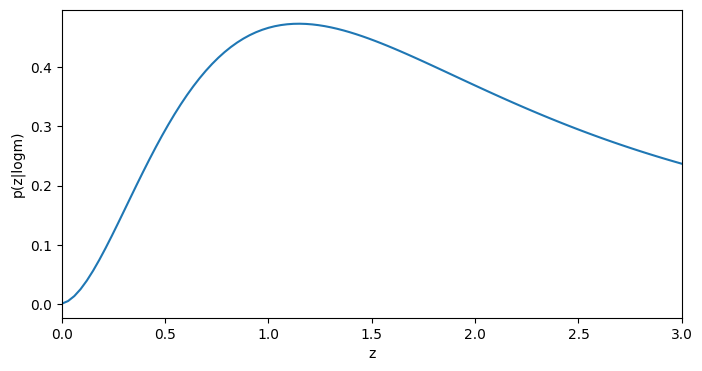

In [18]:
plt.figure(figsize=(8,4))
plot_observed_nz()
plt.xlim(0, 3)

/var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/ipykernel_97374/3311971272.py:22: RuntimeWarning: divide by zero encountered in log10
  return np.log10(mfunc)


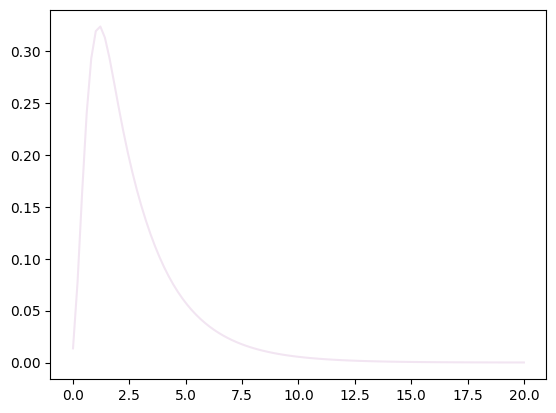

In [35]:
z_grid = np.linspace(0.0, 20.0, 100)
logm_grid = np.linspace(7, 13, 10)
init_sample=1000000
sampled_curves = draw_allowed_parameter_curves(z_grid, init_sample)
plot_nz_prior_draws(z_grid, logm_grid, sampled_curves, 1)

In [39]:
def cdf_z_inverse(z_grid, cz, nsamples):

    z_grid = z_grid[:-1]
    cz = np.tile(cz, (nsamples, 1))
    u = np.ones_like(cz)*np.tile(np.random.uniform(0, 1, (nsamples, 1)), (1, len(z_grid)))
    diff = abs(cz-u)
    min_vals = np.reshape(np.min(diff, axis=1), (nsamples, 1))
    indexes = np.where(diff == np.tile(min_vals, (1, len(z_grid))))

    z_grid = np.tile(z_grid, (nsamples, 1))
    z = z_grid[indexes]

    return z

dz=0.25
z1=0.0
z2=20.0
z_grid = np.linspace(z1, z2, int((z2-z1)/dz)+1)
logm_grid = np.linspace(7, 13, 10)
init_sample=1000000
sampled_curves = draw_allowed_parameter_curves(z_grid, init_sample)


/var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/ipykernel_97374/3311971272.py:22: RuntimeWarning: divide by zero encountered in log10
  return np.log10(mfunc)


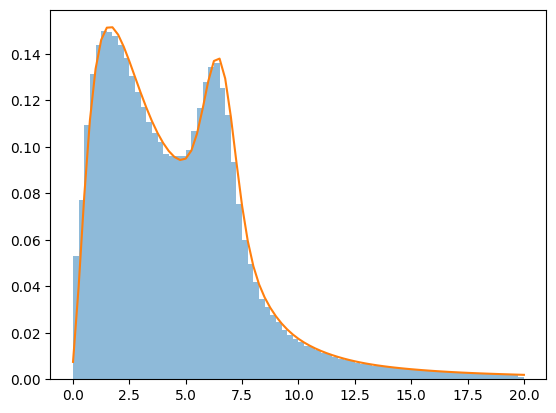

In [42]:
pz = draw_nz_prior(z_grid, logm_grid, sampled_curves)
cz = integrate.cumtrapz(pz, z_grid)

plt.hist(cdf_z_inverse(z_grid, cz, 1000000), density=True, alpha=0.5, bins=z_grid)
plt.plot(z_grid, pz)